In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from model import AutoEncoder, LatentAutoEncoder
from utils import gif_interpolation, draw_reconstruction, random_interpolation
from check_ae import fit_FC

In [5]:
EPOCH = 100
BATCH_SIZE = 100

In [6]:
train_data = torchvision.datasets.MNIST(
    root='datasets/mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)
test_data = torchvision.datasets.MNIST(
    root='datasets/mnist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

In [7]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
sigmas = np.arange(0.01, 0.1, 0.01)

In [10]:
import os

In [21]:
autoencoders = []
PATH = 'saved_models/comparison/standard/'
paths = [path for path in sorted(os.listdir(PATH)) if '.ipynb_checkpoints' not in path]
for model_path, sigma in zip(paths, sigmas):
    if '.ipynb_checkpoints' in model_path: continue
    model = LatentAutoEncoder(256, 'standard', sigma=sigma).cuda()
    model.set_device(); 
    checkpoint_dict = torch.load(os.path.join(PATH, model_path), map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    autoencoders.append(model)

In [29]:
PATH = 'saved_models/comparison/min-max/'
paths = [path for path in sorted(os.listdir(PATH)) if '.ipynb_checkpoints' not in path]
for model_path, sigma in zip(paths, sigmas):
    if '.ipynb_checkpoints' in model_path: continue
    model = LatentAutoEncoder(256, 'min-max', sigma=sigma).cuda()
    model.set_device(); 
    checkpoint_dict = torch.load(os.path.join(PATH, model_path), map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    autoencoders.append(model)

In [26]:
default_ae = AutoEncoder(256).cuda()
optimizer = torch.optim.Adam(default_ae.parameters(), lr=0.001)
loss_func = nn.MSELoss()
for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x_batch = x.view(-1, 28 * 28).cuda()
        y_batch = x.view(-1, 28 * 28).cuda()

        _, decoded = default_ae(x_batch)

        loss = loss_func(decoded, y_batch)
        loss.backward()
        optimizer.step()

In [31]:
scores = []
for i, ae in enumerate(autoencoders):
    scores.append(fit_FC(ae, [train_loader, test_loader], 256, LTAE=True))

In [33]:
default_ae_score = fit_FC(ae, [train_loader, test_loader], 256, LTAE=False)

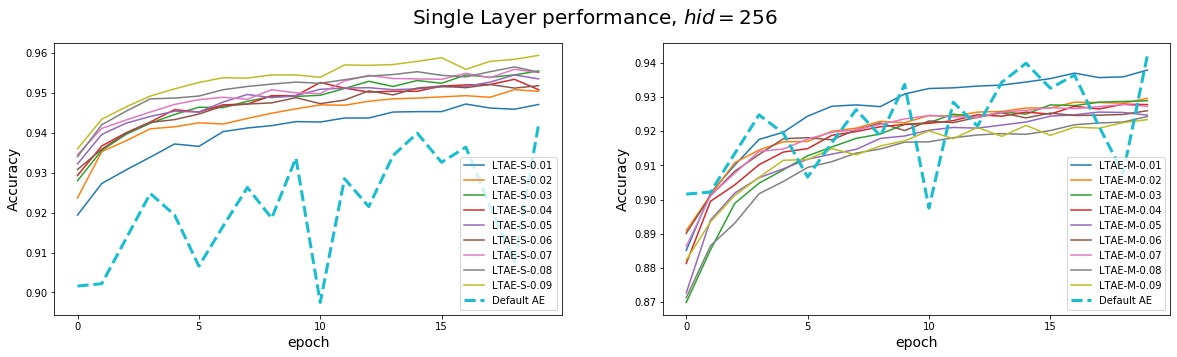

In [85]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
[plt.plot(score, label=f'LTAE-S-{np.round(sigma, 3)}') for score, sigma in zip(scores[:9], sigmas)];
plt.plot(default_ae_score, label=f'Default AE', linestyle='--', linewidth=3)
plt.xticks(list(range(0, 20, 5))); plt.legend();
plt.xlabel('epoch', fontsize=14); plt.ylabel('Accuracy', fontsize=14);

plt.subplot(1, 2, 2)
[plt.plot(score, label=f'LTAE-M-{np.round(sigma, 3)}') for score, sigma in zip(scores[9:], sigmas)];
plt.plot(default_ae_score, label=f'Default AE', linestyle='--', linewidth=3)
plt.xticks(list(range(0, 20, 5))); plt.legend();
plt.xlabel('epoch', fontsize=14); plt.ylabel('Accuracy', fontsize=14);

plt.suptitle('Single Layer performance, $hid=256$', fontsize=20);
plt.savefig('pics/comparison_LTAE.png')